In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from LowerLevel.prox import prox_G,prox_F1_dual,prox_F2_dual
from LowerLevel.pdhg import pdhg
from LowerLevel.cost_utils import *

#Upper level imports
from scipy.sparse.linalg import cg,LinearOperator
import scipy
import time
from UpperLevel.L1norm import *
from UpperLevel.hessians import *
from scipy.optimize.lbfgsb import fmin_l_bfgs_b

In [3]:
u0 = get_sample_data('2d-mri')
u0_mat = (1+0j)*u0.data[125:145,125:145]

In [4]:
n=u0_mat.shape[0]
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0_mat.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0_mat.shape,implementation='cpu')

y = (1+0j)*fourier_op.op(u0_mat)+1e-7*np.random.randn(2*n*n).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [5]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
radial_p = np.zeros((n*n+1,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
radial_p[n*ind1+ind2]=1
radial_p[-1]=1e-6
p = np.copy(radial_p)

#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=1,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"pn1":p[-1],"epsilon":1e-5,"gamma":1e-10}


In [6]:
pysap.Image(data=np.reshape(radial_p[:-1],(n,n))).show()

In [7]:
print(ssim(fourier_op.adj_op(p[:-1]*y),u0_mat))
pysap.Image(data=fourier_op.adj_op(p[:-1]*y)).show()

0.9851392847860889


## Loss function and penalty

In [8]:
c = 1e4
def L(u,u2):return c*np.sum(rho_vec(np.abs(u-u2),1e-10))
def grad_L(u,u2):return c*phix_vec(np.abs(u-u2),1e-10)

beta = 1e-10*c
# def P(p):return beta*np.linalg.norm(p[:-1])**2
# def grad_P(p):
#     Dp = 2*beta*p
#     Dp[-1] = 0
#     return Dp

def P(p):return beta*np.sum(p[:-1]*(2-p[:-1]))
def grad_P(p):
    Dp = np.zeros(n**2+1)
    Dp[:-1] = 2*beta*(1-p[:-1])
    return Dp

In [9]:
param["pn1"]=1e-6
p = np.copy(radial_p)
uk,norms,energy = pdhg(y,p[:-1],fourier_op,linear_op,param,maxit=30,verbose=0)
print(f"\nL(u(p))={L(uk,u0_mat)}\nP(p)={P(p)}")

Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.1430339813232422 seconds.

L(u(p))=2.323543849233845
P(p)=0.000309


/home/guillaume/anaconda3/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:17: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))


# Upper level energy

In [10]:
def E(pk):
    print("\nEvaluating E(p)")
    param["pn1"]=pk[-1]
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=20,verbose=0)
    return L(uk,u0_mat)+P(pk)

cgconv = []
def grad_E(pk,max_cgiter=2000,cgtol=1e-8,compute_conv=False):
    global cgconv
    #Compute uk from pk with lower level solver
    param["pn1"]=pk[-1]
    print("\nStarting PDHG")
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=50,verbose=0)
    
    #Defining linear operator from pk and uk
    def mv(w):
        w_complex = np.reshape( w[:n**2]+1j*w[n**2:] , (n,n) )
        fx = np.reshape(Du2_Etot( uk , pk , w_complex ,
                                   eps=param["epsilon"],
                                   fourier_op=fourier_op,
                                   y=y,
                                   linear_op=linear_op,
                                   gamma=param["gamma"]),(n**2,))
        return np.concatenate([np.real(fx),np.imag(fx)])
    
    
    # -- Use cg to compute gradient --
    lin = LinearOperator((2*n**2,2*n**2),matvec=mv)
    B = np.reshape(np.conj(grad_L(uk,u0_mat).transpose()),(n**2,))
    B_real = np.concatenate([np.real(B),np.imag(B)])
    def cgcall(x):
        if compute_conv:cgconv.append(np.linalg.norm(lin(x)-B_real)/np.linalg.norm(B_real))
    
    t1=time.time()
    print("\nStarting Conjugate Gradient method")
    x_inter,convergence = scipy.sparse.linalg.cg(lin,B_real,tol=cgtol,maxiter=max_cgiter,callback=cgcall)
    print(f"Finished in {time.time()-t1}s - ||Ax-b||/||b||: {np.linalg.norm(lin(x_inter)-B_real)/np.linalg.norm(B_real)}")

    #Apply DpuE
    return -Dpu_Etot(uk,pk,np.reshape( x_inter[:n**2]+1j*x_inter[n**2:] , (n,n) ),
                                   eps=param["epsilon"],
                                   fourier_op=fourier_op,
                                   y=y,
                                   linear_op=linear_op,
                                   gamma=param["gamma"]) + grad_P(pk)

In [11]:
#Checking if conjugate gradient converges
cgconv = []
p=0.9*radial_p+0.1*np.random.rand(n**2+1)
p[-1]=1e-6
gP = grad_E(p,max_cgiter=10000,cgtol=1e-8,compute_conv=True)


Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.08107900619506836 seconds.

Starting Conjugate Gradient method
Finished in 6.15185284614563s - ||Ax-b||/||b||: 9.279419245658768e-09


Text(0, 0.5, '||Ax-b||/||b||')

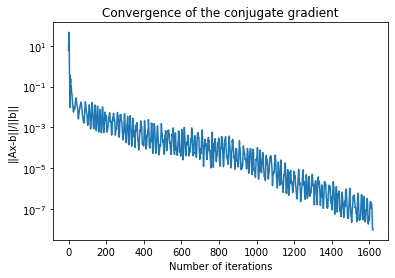

In [12]:
plt.plot(cgconv)
plt.yscale("log")
plt.title("Convergence of the conjugate gradient")
plt.xlabel("Number of iterations")
plt.ylabel("||Ax-b||/||b||")
#plt.savefig("Upper Level/CG_conv.png")

In [13]:
# Checking gradE
p0 = np.random.rand(n**2+1)
p0[-1] = 1e-6
Ep0,gradEp0 = E(p0),grad_E(p0)
p1 = np.random.rand(n**2+1)

tests = np.logspace(-10,-2,50)
real_values = np.array([E(p0+t*p1) for t in tests])
approx = np.array([Ep0+np.sum(gradEp0*t*p1) for t in tests])


Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.05327796936035156 seconds.

Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.07923245429992676 seconds.

Starting Conjugate Gradient method
Finished in 3.441023588180542s - ||Ax-b||/||b||: 9.193438116320628e-09

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.031401872634887695 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.03136801719665527 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.03137707710266113 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.031412363052368164 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.03218960762023926 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.032071590423583984 seconds.

Evaluating E(p)
Sigma: 0.44


Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.0594480037689209 seconds.
25.655006071261894


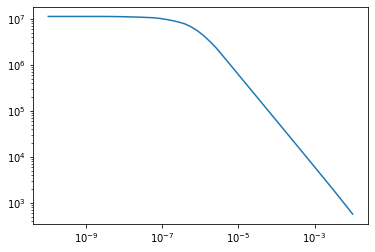

In [14]:
print(E(p0))
plt.plot(tests,abs((real_values-approx))/tests)
plt.xscale("log")
plt.yscale("log")

# L-BFGS-B

In [15]:
# p0 = 0.9*p+0.1*np.random.rand(n**2+1)
p0 = np.random.rand(n**2+1)
# p0=np.ones(n**2+1)
# p0=radial_p
p0[-1] = 1e-6

# Callback function
niter = 0
def fcall(x):
    global uk,niter
    niter += 1
    print("\033[1m" + f"\n{niter} iterations: E(p)={E(x)}, alpha={x[-1]}\n\n" + "\033[0m")

In [16]:
niter = 0
pf,Emin,info = fmin_l_bfgs_b(E,p0,grad_E,bounds=[(0,1)]*n**2+[(0,np.inf)],pgtol=1e-6,
                           maxfun=10,maxiter=10,
                            callback = fcall)


Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.06439399719238281 seconds.

Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.09189987182617188 seconds.

Starting Conjugate Gradient method
Finished in 2.337127685546875s - ||Ax-b||/||b||: 8.988585543540523e-09

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.03386735916137695 seconds.

Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.0700838565826416 seconds.

Starting Conjugate Gradient method
Finished in 1.7228541374206543s - ||Ax-b||/||b||: 6.7130931970389476e-09

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.031846046447753906 seconds.

Starting PDHG
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.07958626747131348 seconds.

Starting Conjugate Gradient method
Finished in 3.521791696548462s - ||Ax-b||/||b||: 9.720463536891498e-09

Evaluating E(p)
Sigma: 0.447213595

In [17]:
print(E(p0),E(pf))


Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.043840646743774414 seconds.

Evaluating E(p)
Sigma: 0.4472135954999579 
Tau: 1.118033988749895
Finished in 0.03195357322692871 seconds.
18.980150791858645 18.980150791858645


In [18]:
#print(pf[-1])
pysap.Image(data=np.reshape(p0[:-1]-pf[:-1],(n,n))).show()

In [19]:
np.sum(p0),np.sum(pf)

(195.91317161457206, 195.91317161457206)

In [20]:
uk,norms,energy,ssims = pdhg(y,pf[:-1],fourier_op,linear_op,param,ground_truth=u0_mat,maxit=100)

Sigma: 0.4472135954999579 
Tau: 1.118033988749895
10  iterations:
Cost: 1.1825636384741078e-09 
Norm: 0.05637273235094342 

20  iterations:
Cost: 1.1707558781487392e-09 
Norm: 0.009514084956043492 

30  iterations:
Cost: 1.1696849429459187e-09 
Norm: 0.003230822634535401 

40  iterations:
Cost: 1.169507686446375e-09 
Norm: 0.0013906734193510995 

50  iterations:
Cost: 1.1694543266318818e-09 
Norm: 0.0006694712085524863 

60  iterations:
Cost: 1.1694321805892373e-09 
Norm: 0.0003681132328882045 

70  iterations:
Cost: 1.1694217048739649e-09 
Norm: 0.00021627318836225538 

80  iterations:
Cost: 1.1694168229915808e-09 
Norm: 0.00013182517948332338 

Finished in 0.39435362815856934 seconds.


0.640721881090328


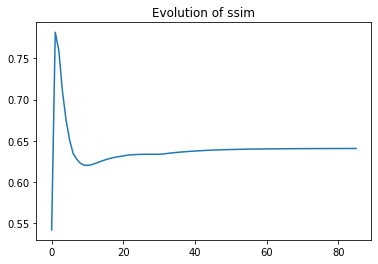

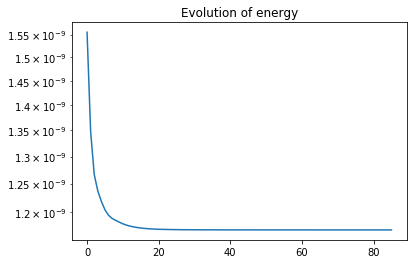

In [21]:
print(ssim(uk,u0_mat))

plt.figure()
plt.plot(ssims)
plt.title("Evolution of ssim")
plt.show()

plt.figure()
plt.plot(energy)
plt.title("Evolution of energy")
plt.yscale("log")
plt.show()

pysap.Image(data=uk).show()